In [1]:
# packages
import numpy as np
import pandas as pd
import geopandas as gpd
import elapid as ela
import matplotlib.pyplot as plt
import matplotlib as mpl

In [63]:
# paths
base = "/Users/christopher/data/bigtrees/"
plots = base + "plots/"
rasters = [
    "SierraEcoregion-Elevation-DEM-Summer-2020-00030m.tif",
    "SierraEcoregion-Disturbance-Management-2020-Summer-00030m.tif",
    "SierraEcoregion-Disturbance-TimeSinceFire-2020-Summer-00030m.tif",
    "SierraEcoregion-Vegetation-AbovegroundCarbonDensity-2020-Spring-00030m.tif",
    "SierraEcoregion-Vegetation-CanopyHeight-2020-Spring-00030m.tif",
    "SierraEcoregion-Vegetation-TallTrees-2020-Spring-00030m.tif",
    "SierraEcoregion-Wildfire-ScaledHazard-2020-Summer-00030m.tif",
    "ecoregion_model_current_mean.tif",
    "ecoregion_model_rcp45_mean.tif",
    "ecoregion_model_rcp85_mean.tif",
    "ecoregion_model_current_stdv.tif",
    "ecoregion_model_rcp45_stdv.tif",
    "ecoregion_model_rcp85_stdv.tif",
]
rasters = [base + raster for raster in rasters]
labels = [
    "Elevation",
    "Slope",
    "Aspect",
    "YearsSinceManagement",
    "YearsSinceFire",
    "AbovegroundCarbonDensity",
    "CanopyHeight",
    "IsTall",
    "Hazard",
    "SuitabilityCurrent",
    "SuitabilityRCP45",
    "SuitabilityRCP85",
    "SuitabilityCurrentSTDV",
    "SuitabilityRCP45STDV",
    "SuitabilityRCP85STDV",
]
points = base + "point-samples-all.gpkg"

## Reading and cleaning data

In [64]:
# data loading and point annotation
df = gpd.read_file(points)
df = ela.annotate(df, rasters, labels=labels)

Raster:   0%|                              | 0/13 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

Sample:   0%|                              | 0/177090 [00:00<?, ?it/s]

In [67]:
# remove geometry column
df = df.drop(columns=['geometry'])

# remove non-vegetated pixels
has_trees = df['CanopyHeight'] > 0
df = df[has_trees]
df.reset_index(drop=True)

# set variables for indexing tall/non-tall pixels
is_tall = df['IsTall'] == 1
not_tall = df['IsTall'] == 0

## Basic Histogram Plotting

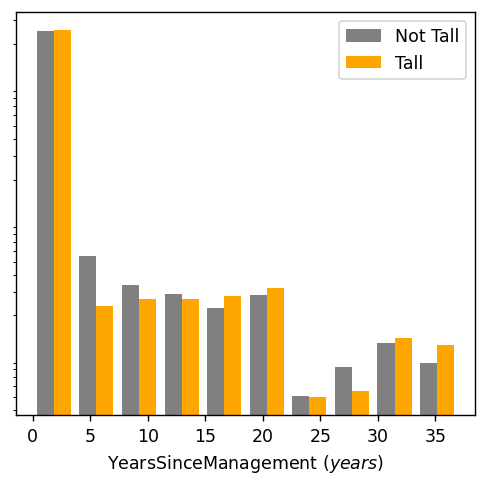

In [80]:
# exploratory plotting
var = 'YearsSinceManagement'
units = 'years'
labels = ["Not Tall", "Tall"]
colors = ["gray", "orange"]
bins = 10

# plotting
plt.figure(figsize=(4,4), dpi=125)
plt.hist(
    [df[not_tall][var], df[is_tall][var]],
    density=True,
    color=colors,
    bins=bins,
    label=labels,
    log=True
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(plots + f"hist-istall-{var}.png", dpi=150)

# Carbon content

Though Tall Trees occupy a small fraction of the total area (here, 10%), they store a disporportionately large amount of carbon. How much relative to the total carbon stocks are stored within areas with tall trees?

In [70]:
# compute the area per pixel in hectares
area_per_pixel = (30 * 30) / (100 * 100)

# average carbon densities
acd_is_tall = df[is_tall]['AbovegroundCarbonDensity']
acd_not_tall = df[not_tall]['AbovegroundCarbonDensity']
acd_is_tall_mean = acd_is_tall.mean()
acd_not_tall_mean = acd_not_tall.mean()

# total area per group
area_is_tall = len(acd_is_tall) * area_per_pixel
area_not_tall = len(acd_not_tall) * area_per_pixel

# total carbon
carbon_is_tall = int(area_is_tall * acd_is_tall_mean)
carbon_not_tall = int(area_not_tall * acd_not_tall_mean)
total_carbon = carbon_is_tall + carbon_not_tall
fraction_tall_carbon = 100 * (carbon_is_tall / total_carbon)

print(f"Total carbon: {total_carbon:,} Mg C")
print(f"Tall tree carbon: {carbon_is_tall:,} Mg C")
print(f"Percent carbon in tall trees: {fraction_tall_carbon:0.1f}%")

Total carbon: 553,859 Mg C
Tall tree carbon: 146,143 Mg C
Percent carbon in tall trees: 26.4%


## Hazard binning

Wildfire hazard percentiles describe the relative hazard across the region, and it doesn't look like there are uniform differences in hazard scores between areas with and without tall trees. This doesn't mean that there are no regions without high hazards, however.

Where are the areas with high hazard scores? What environmental differences emerge between low, moderate, and high hazard areas?

In [82]:
# mapping
high_hazard = df['Hazard'] > 66
low_hazard = df['Hazard'] < 33
mid_hazard = ~high_hazard * ~low_hazard

True

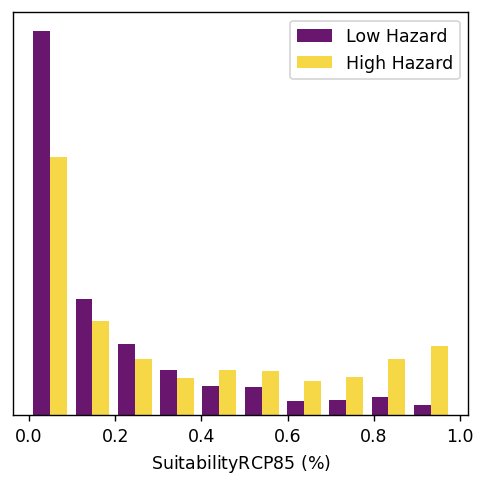

In [111]:
# exploratory plotting
var = 'SuitabilityRCP85'
units = '\%'
labels = ["Low Hazard", "High Hazard"]
colors = ["#69166e", "#f6d746"]
bins = 10

# plotting
plt.figure(figsize=(4,4), dpi=125)
plt.hist(
    [df[low_hazard][var], df[high_hazard][var]],
    density=True,
    color=colors,
    bins=bins,
    label=labels,
    log=False
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(plots + f"hist-istall-{var}.png", dpi=150)

## Future bioclimatic suitability binning

We have a range of future climatic suitability scores

In [160]:
# suitability change
diff_rcp45 = df['SuitabilityRCP45'] - df['SuitabilityCurrent']
diff_rcp85 = df['SuitabilityRCP85'] - df['SuitabilityCurrent']

# use the sum of 3x the standard deviations to flag significant change
margin_rcp45 = 3*df['SuitabilityRCP45STDV'] + 3*df['SuitabilityCurrentSTDV']
margin_rcp85 = 3*df['SuitabilityRCP85STDV'] + 3*df['SuitabilityCurrentSTDV']

# negative change
#neg_rcp45 = (df['SuitabilityRCP45'] + 3*df['SuitabilityRCP45STDV']) - (df['SuitabilityCurrent'] - 3*df['SuitabilityCurrentSTDV']) < 0
#neg_rcp85 = (df['SuitabilityRCP85'] + 3*df['SuitabilityRCP85STDV']) - (df['SuitabilityCurrent'] - 3*df['SuitabilityCurrentSTDV']) < 0
neg_rcp45 = diff_rcp45 < -margin_rcp45
neg_rcp85 = diff_rcp85 < -margin_rcp85
neg_rcp45_pct = 100 * (neg_rcp45.sum() / len(neg_rcp45))
neg_rcp85_pct = 100 * (neg_rcp85.sum() / len(neg_rcp85))

print("Negative suitability change:")
print(f"RCP45: {neg_rcp45_pct:0.1f}%, RCP85: {neg_rcp85_pct:0.1f}%")

# positive change
#pos_rcp45 = (df['SuitabilityRCP45'] - 3*df['SuitabilityRCP45STDV']) - (df['SuitabilityCurrent'] + 3*df['SuitabilityCurrentSTDV']) > 0
#pos_rcp85 = (df['SuitabilityRCP85'] - 3*df['SuitabilityRCP85STDV']) - (df['SuitabilityCurrent'] + 3*df['SuitabilityCurrentSTDV']) > 0
pos_rcp45 = diff_rcp45 > margin_rcp45
pos_rcp85 = diff_rcp85 > margin_rcp85
pos_rcp45_pct = 100 * (pos_rcp45.sum() / len(pos_rcp45))
pos_rcp85_pct = 100 * (pos_rcp85.sum() / len(pos_rcp85))

print("Positive suitability change:")
print(f"RCP45: {pos_rcp45_pct:0.1f}%, RCP85: {pos_rcp85_pct:0.1f}%")

# Add change data to df, add binary maps
df['SuitabilityRCP45Change'] = diff_rcp45
df['SuitabilityRCP85Change'] = diff_rcp85

# and estimate where no change occurs
null_rcp45 = ~neg_rcp45 * ~pos_rcp45
null_rcp85 = ~neg_rcp85 * ~pos_rcp85

Negative suitability change:
RCP45: 3.9%, RCP85: 26.2%
Positive suitability change:
RCP45: 69.2%, RCP85: 48.5%


In [155]:
# save for later
df.to_csv('point-samples-annotated-hazard.csv')

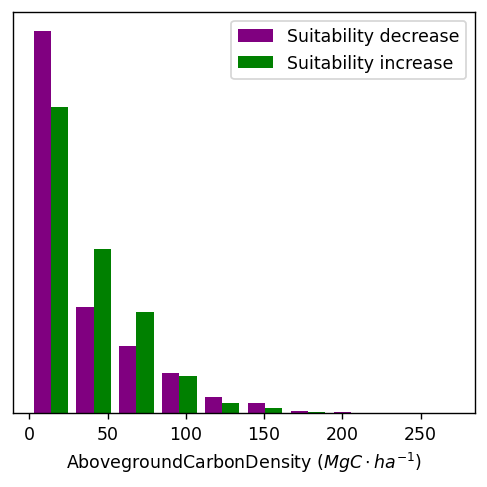

In [168]:
# exploratory plotting
var = 'AbovegroundCarbonDensity'
units = 'MgC \cdot ha^{-1}'
labels = ["Suitability decrease", "Suitability increase"]
colors = ["purple", "green"]
bins = 10

# plotting
plt.figure(figsize=(4,4), dpi=125)
plt.hist(
    [df[neg_rcp85][var], df[pos_rcp85][var]],
    density=True,
    color=colors,
    bins=bins,
    label=labels,
    log=False
)

# labels
plt.xlabel(f"{var} (${units}$)")
plt.ylabel(None)
plt.yticks([], [])

# figure
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig(plots + f"hist-change_rcp85-{var}.png", dpi=150)